- https://www.kaggle.com/raddar/paris-madness/notebook

- features와 boxscore를 어떻게 설정하느냐에 따라 0.1~0.2 정도의 성능차이가 남

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import shap

# Load the data

In [2]:
# Environment Kaggle or Local?
ENVIRONMENT = 'local'

# Competition year 2019? or 2020?
COMPETITION_YEAR = 2019

In [3]:
if ENVIRONMENT == 'local' and COMPETITION_YEAR == 2019:
    tourney_detail = pd.read_csv('input/MDataFiles_Stage1/NCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('input/MDataFiles_Stage1/NCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('input/MDataFiles_Stage1/NCAATourneySeeds.csv')
    regular_detail = pd.read_csv('input/MDataFiles_Stage1/Prelim2019_RegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('input/MDataFiles_Stage1/Prelim2019_RegularSeasonDetailedResults.csv')
    submission = pd.read_csv('input/SampleSubmissionStage2.csv')
    
elif ENVIRONMENT == 'local' and COMPETITION_YEAR == 2020:
    tourney_detail = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneySeeds.csv')
    regular_detail = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    submission = pd.read_csv('input/MSampleSubmissionStage1_2020.csv')

elif ENVIRONMENT == 'kaggle' and COMPETITION_YEAR == 2019:
    tourney_detail = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneySeeds.csv')
    regular_detail = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Prelim2019_RegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Prelim2019_RegularSeasonDetailedResults.csv')
    submission = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/SampleSubmissionStage2.csv')


In [4]:
tourney_detail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,2018,146,1242,85,1181,81,N,1,30,69,...,29,14,18,10,22,13,11,9,3,16
1044,2018,146,1437,71,1403,59,N,0,19,57,...,20,14,18,11,22,7,9,4,1,23
1045,2018,152,1276,69,1260,57,N,0,25,59,...,10,12,14,6,26,6,17,5,1,17
1046,2018,152,1437,95,1242,79,N,0,36,65,...,21,16,20,10,23,8,9,5,1,12


In [5]:
seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159


In [6]:
regular_detail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87361,2019,128,1412,70,1292,61,N,0,24,49,...,30,3,6,10,20,13,14,5,3,20
87362,2019,128,1417,79,1390,72,N,0,25,61,...,25,11,20,18,30,11,12,7,9,22
87363,2019,128,1425,78,1112,65,N,0,29,60,...,22,14,19,11,28,11,12,3,6,17
87364,2019,128,1439,71,1274,56,N,0,27,54,...,29,10,14,10,20,10,8,3,0,10


In [7]:
regular_detail.groupby('Season').mean().head()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,0.061308,26.299393,55.367851,6.695624,17.377166,...,18.720971,12.193674,18.055243,11.913345,21.115901,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,0.071319,25.928681,55.069350,6.708160,17.570335,...,18.825202,12.025159,18.057755,11.844235,21.224021,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,0.066524,25.975187,54.949305,6.769840,17.678503,...,18.922139,11.875722,17.767059,11.733690,21.038717,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,0.073996,25.920538,54.881228,6.845281,17.821526,...,18.882279,11.807862,17.589027,11.762035,20.874711,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,0.067618,25.896887,54.196907,7.043228,18.138608,...,19.453500,11.862978,17.645251,11.534404,20.671227,11.667460,15.218917,6.225858,2.760658,19.985524


In [8]:
tourney_detail.groupby('Season').mean().head()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,
2003,139.15625,1283.343750,76.562500,1288.765625,65.546875,0.093750,27.703125,57.906250,6.640625,16.281250,...,19.968750,12.281250,17.796875,12.421875,21.171875,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.15625,1286.515625,75.500000,1300.640625,64.265625,0.046875,25.890625,54.531250,6.906250,17.500000,...,20.468750,11.781250,16.750000,11.734375,20.593750,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.15625,1306.031250,75.562500,1299.562500,65.375000,0.109375,26.281250,54.609375,6.953125,18.015625,...,19.734375,11.984375,17.234375,12.359375,20.984375,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.15625,1282.250000,73.203125,1291.500000,63.171875,0.109375,24.984375,54.093750,6.609375,18.015625,...,19.890625,11.031250,15.625000,11.859375,21.375000,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.15625,1320.593750,75.703125,1299.421875,63.578125,0.093750,25.515625,54.250000,7.421875,18.406250,...,19.984375,11.656250,16.875000,11.359375,20.406250,11.500000,12.468750,5.906250,2.843750,20.328125


In [9]:
# Check if all columns are the same between regular_detail and tourney_detail
all(regular_detail.columns == tourney_detail.columns)

True

# Data Preparation

In [10]:
regular_detail.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [11]:
# Swap the features of winning team and losing team
regular_detail_swap = regular_detail[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [12]:
# Change winning location: "Home" to "Away", "Away" to "Home"
regular_detail_swap.loc[regular_detail['WLoc'] == 'H', 'WLoc'] = 'A'
regular_detail_swap.loc[regular_detail['WLoc'] == 'A', 'WLoc'] = 'H'

# Change "WLoc" to "location"
regular_detail.columns.values[6] = 'location'
regular_detail_swap.columns.values[6] = 'location'

In [13]:
# Change letter 'W' to 'T1_' and 'L' to 'T2_'
regular_detail.columns = [column.replace('W','T1_').replace('L','T2_') for column in regular_detail.columns]

# Change letter 'L' to 'T1_' and 'W' to 'T2_'
regular_detail_swap.columns = [column.replace('L','T1_').replace('W','T2_') for column in regular_detail.columns]

In [14]:
regular_detail.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [15]:
regular_detail_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,68,N,0,22,53,...,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,...,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,...,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,...,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,...,14,11,13,17,22,12,14,4,4,20


In [16]:
# Concat regular_detail and regular_detail_swap together
regular_data = pd.concat([regular_detail, regular_detail_swap]).sort_index().reset_index(drop = True)

### Apply function to prepare data

In [17]:
def prepare_data(df):
    # Swap winnig team's columns and losing team's columns
    df_swap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    df_swap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    df_swap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    df_swap.columns.values[6] = 'location'    
      
    df.columns = [column.replace('W','T1_').replace('L','T2_') for column in df.columns]
    df_swap.columns = [column.replace('L','T1_').replace('W','T2_') for column in df_swap.columns]

    df_concat = pd.concat([df, df_swap]).reset_index(drop=True)
    
    # -1, 0, 1 encoding
    df_concat.loc[df_concat.location=='N','location'] = '0'
    df_concat.loc[df_concat.location=='H','location'] = '1'
    df_concat.loc[df_concat.location=='A','location'] = '-1'
    df_concat.location = df_concat.location.astype(int)
    
    df_concat['PointDiff'] = df_concat['T1_Score'] - df_concat['T2_Score']
    
    return df_concat

In [18]:
# Reload data ot put into the function
regular_data = prepare_data(regular_detail_reload)
tourney_data = prepare_data(tourney_detail_reload)

In [19]:
regular_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,...,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,...,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,...,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,...,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,...,17,27,21,15,12,10,7,1,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174727,2019,128,1292,61,1412,70,0,0,24,58,...,17,24,8,24,8,11,7,2,11,-9
174728,2019,128,1390,72,1417,79,0,0,27,76,...,22,35,12,37,9,15,7,1,20,-7
174729,2019,128,1112,65,1425,78,0,0,23,57,...,12,19,6,24,10,8,6,5,19,-13
174730,2019,128,1274,56,1439,71,0,0,19,56,...,6,7,8,28,17,10,4,3,15,-15


In [20]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,...,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,...,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,...,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,...,15,20,10,26,16,14,5,8,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,0,1,30,70,...,12,15,17,30,20,18,5,3,14,-4
2092,2018,146,1403,59,1437,71,0,0,20,60,...,29,35,20,31,7,12,6,4,17,-12
2093,2018,152,1260,57,1276,69,0,0,22,51,...,12,18,11,25,8,11,10,2,11,-12
2094,2018,152,1242,79,1437,95,0,0,28,62,...,5,7,7,26,20,10,3,5,14,-16


# Feature engineering

In [21]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [22]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [23]:
season_team_boxscore_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_team_boxscore_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,...,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [24]:
season_team_boxscore_statistics.columns = [''.join(col).strip() for col in season_team_boxscore_statistics.columns.values]
season_team_boxscore_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [25]:
season_T1_boxscore_stat = season_team_boxscore_statistics.copy()
season_T2_boxscore_stat = season_team_boxscore_statistics.copy()

season_T1_boxscore_stat.columns = ["T1_" + column.replace("T1_","").replace("T2_","opponent_") for column in season_T1_boxscore_stat.columns]
season_T2_boxscore_stat.columns = ["T2_" + column.replace("T1_","").replace("T2_","opponent_") for column in season_T2_boxscore_stat.columns]
season_T1_boxscore_stat.columns.values[0] = "Season"
season_T2_boxscore_stat.columns.values[0] = "Season"

In [26]:
season_T1_boxscore_stat.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [27]:
season_T2_boxscore_stat.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [28]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

In [29]:
tourney_data = pd.merge(tourney_data, season_T1_boxscore_stat, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_T2_boxscore_stat, on = ['Season', 'T2_TeamID'], how = 'left')

In [30]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [31]:
# Extract the last 14days statistics (132 - 14 = 118)
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
# Winning rate of each team according to the season
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [32]:
last14days_stats_T1

,Season,T1_TeamID,T1_win_ratio_14d
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.333333
3,2003,1105,0.000000
4,2003,1106,0.500000
...,...,...,...
5611,2019,1462,0.500000
5612,2019,1463,0.500000
5613,2019,1464,0.000000
5614,2019,1465,0.500000


In [33]:
last14days_stats_T2

,Season,T2_TeamID,T2_win_ratio_14d
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.333333
3,2003,1105,0.000000
4,2003,1106,0.500000
...,...,...,...
5611,2019,1462,0.500000
5612,2019,1463,0.500000
5613,2019,1464,0.000000
5614,2019,1465,0.500000


In [34]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [35]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,7.735294,23.676471,11.911765,12.676471,13.000000,5.617647,3.558824,10.558824,0.500000,0.800000
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,7.000000,21.352941,9.558824,14.000000,13.117647,4.558824,2.676471,16.176471,0.500000,1.000000
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,5.558824,16.235294,7.970588,10.470588,12.852941,4.088235,3.235294,10.117647,1.000000,1.000000
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,7.000000,21.352941,9.558824,14.000000,13.117647,4.558824,2.676471,16.176471,0.800000,1.000000


In [36]:
seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374


In [37]:
seeds_T1 = seeds[['Season','TeamID','Seed']].copy()
seeds_T2 = seeds[['Season','TeamID','Seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [38]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [39]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,12.676471,13.000000,5.617647,3.558824,10.558824,0.500000,0.800000,2,1,1
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,14.000000,13.117647,4.558824,2.676471,16.176471,0.500000,1.000000,3,1,2
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,10.470588,12.852941,4.088235,3.235294,10.117647,1.000000,1.000000,11,3,8
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,14.000000,13.117647,4.558824,2.676471,16.176471,0.800000,1.000000,1,1,0


In [40]:
# Add Score Sum Feature
season_team_score_sum = regular_data.groupby(['Season', 'T1_TeamID'])['T1_Score'].sum().reset_index()
season_team_score_sum.rename(columns={'T1_TeamID': 'TeamID', 'T1_Score': 'Score_Sum'}, inplace=True)
season_team_score_sum

,Season,TeamID,Score_Sum
0,2003,1102,1603
1,2003,1103,2127
2,2003,1104,1940
3,2003,1105,1866
4,2003,1106,1781
...,...,...,...
5829,2019,1462,2242
5830,2019,1463,2085
5831,2019,1464,2205
5832,2019,1465,1962


In [41]:
tourney_data = pd.merge(tourney_data, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T1_TeamID'],
                        right_on=['Season', 'TeamID'])
tourney_data.rename(columns={'Score_Sum': 'T1_Score_Sum'}, inplace=True)
tourney_data.drop(['TeamID'], axis=1, inplace=True)
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0,2065
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15,2386
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3,2203
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5,2301
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1,2160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,13.000000,5.617647,3.558824,10.558824,0.500000,0.800000,2,1,1,2795
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,13.117647,4.558824,2.676471,16.176471,0.500000,1.000000,3,1,2,2483
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,12.852941,4.088235,3.235294,10.117647,1.000000,1.000000,11,3,8,2294
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,13.117647,4.558824,2.676471,16.176471,0.800000,1.000000,1,1,0,2771


In [42]:
tourney_data = pd.merge(tourney_data, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T2_TeamID'],
                        right_on=['Season', 'TeamID'])
tourney_data.rename(columns={'Score_Sum': 'T2_Score_Sum'}, inplace=True)
tourney_data.drop(['TeamID'], axis=1, inplace=True)
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0,2065,2184
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15,2386,1966
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3,2203,2161
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5,2301,2615
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1,2160,2172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,5.617647,3.558824,10.558824,0.500000,0.800000,2,1,1,2795,2771
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,4.558824,2.676471,16.176471,0.500000,1.000000,3,1,2,2483,2960
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,4.088235,3.235294,10.117647,1.000000,1.000000,11,3,8,2294,2504
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,4.558824,2.676471,16.176471,0.800000,1.000000,1,1,0,2771,2960


In [43]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
regular_season_effects

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1266,1437,12,1
3,2003,1296,1457,6,1
4,2003,1400,1208,6,1
...,...,...,...,...,...
174727,2019,1292,1412,-9,0
174728,2019,1390,1417,-7,0
174729,2019,1112,1425,-13,0
174730,2019,1274,1439,-15,0


In [44]:
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
march_madness

,Season,T1_TeamID,T2_TeamID
0,1985,1207,1207
1,1985,1207,1210
2,1985,1207,1228
3,1985,1207,1260
4,1985,1207,1374
...,...,...,...
149397,2019,1205,1332
149398,2019,1205,1414
149399,2019,1205,1330
149400,2019,1205,1159


In [45]:
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1
...,...,...,...,...,...
9857,2019,1439,1199,-9,0
9858,2019,1279,1246,-4,0
9859,2019,1280,1397,-17,0
9860,2019,1397,1120,-4,0


In [46]:
# Function to add quality feature
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [47]:
glm_quality = pd.concat([
                        team_quality(2003),
                        team_quality(2004),
                        team_quality(2005),
                        team_quality(2006),
                        team_quality(2007),
                        team_quality(2008),
                        team_quality(2009),
                        team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                        team_quality(2019)]).reset_index(drop=True)

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\pan

In [48]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [49]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [50]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,1.966667,1.000000,0.833333,16,16,0,2065,2184,1.344286e-49,1.568239e-18
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,4.655172,0.666667,1.000000,1,16,-15,2386,1966,4.934326e+00,1.656674e-18
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,8.689655,0.666667,0.750000,10,7,3,2203,2161,3.521347e-01,1.194127e+00
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,14.909091,1.000000,1.000000,11,6,5,2301,2615,NaN,2.604195e+00
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,4.400000,0.333333,0.600000,8,9,-1,2160,2172,9.548861e-01,9.477385e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2018,146,1181,81,1242,85,30.545455,61.939394,8.303030,21.969697,...,10.558824,0.500000,0.800000,2,1,1,2795,2771,0.000000e+00,inf
2092,2018,146,1403,59,1437,71,26.151515,56.363636,7.030303,19.212121,...,16.176471,0.500000,1.000000,3,1,2,2483,2960,inf,inf
2093,2018,152,1260,57,1276,69,26.000000,51.343750,7.343750,18.343750,...,10.117647,1.000000,1.000000,11,3,8,2294,2504,inf,0.000000e+00
2094,2018,152,1242,79,1437,95,30.117647,60.529412,10.147059,25.205882,...,16.176471,0.800000,1.000000,1,1,0,2771,2960,inf,inf


# Modeling

In [51]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2096.00000
mean        0.00000
std        14.28837
min       -56.00000
25%       -10.00000
50%         0.00000
75%        10.00000
max        56.00000
dtype: float64

In [52]:
# The most important 9 features
features = ['T2_seed', 'T1_seed', 'Seed_diff', 'T2_PointDiffmean',
       'T1_PointDiffmean', 'T2_Score_Sum', 'T1_Score_Sum',
        'T1_opponent_FGAmean', 'T2_opponent_FGAmean']


'''features = ['T1_seed', 'T2_seed', 'Seed_diff', 
            'T1_PointDiffmean', 'T2_PointDiffmean',
            'T1_Score_Sum', 'T2_Score_Sum', 
            'T1_quality', 'T2_quality',
            'T1_FGMmean', 'T2_FGMmean',
           'T1_win_ratio_14d', 'T2_win_ratio_14d']'''


'''features = ['T1_seed', 'T2_seed', 'Seed_diff', 'T1_PointDiffmean',
       'T2_PointDiffmean', 'T2_Score_Sum', 'T1_opponent_FGAmean',
       'T1_Score_Sum', 'T2_opponent_FGAmean', 'T2_FGMmean', 'T1_FGMmean',
       'T1_win_ratio_14d']'''

len(features)

9

In [53]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [54]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [55]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [56]:
xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.2078+0.121122	test-mae:11.2132+0.495748
[50]	train-mae:8.55436+0.0605071	test-mae:8.82382+0.306362
[100]	train-mae:8.3139+0.0670491	test-mae:8.76895+0.278947
Fold repeater 1
[0]	train-mae:11.2077+0.0463429	test-mae:11.2167+0.180659
[50]	train-mae:8.54692+0.045986	test-mae:8.85038+0.205977
Fold repeater 2
[0]	train-mae:11.2102+0.0599764	test-mae:11.2175+0.242594
[50]	train-mae:8.55024+0.056363	test-mae:8.84435+0.228248
Fold repeater 3
[0]	train-mae:11.2111+0.107439	test-mae:11.2174+0.431121
[50]	train-mae:8.55456+0.102306	test-mae:8.81017+0.391775
[100]	train-mae:8.31047+0.109093	test-mae:8.76542+0.415914
Fold repeater 4
[0]	train-mae:11.2137+0.0610669	test-mae:11.219+0.244956
[50]	train-mae:8.54649+0.0896672	test-mae:8.81692+0.344924
[100]	train-mae:8.302+0.0779086	test-mae:8.76904+0.31159
Fold repeater 5
[0]	train-mae:11.2099+0.0743402	test-mae:11.2171+0.317714
[50]	train-mae:8.55167+0.0196466	test-mae:8.83327+0.074509
[100]	train-mae:8.30055+0.0261176

In [57]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([83, 72, 69, 77, 81, 89, 93, 84, 83, 76],
 [8.761675,
  8.815735,
  8.8027914,
  8.755575799999999,
  8.762243999999999,
  8.791843,
  8.774466199999999,
  8.781952,
  8.788853799999998,
  8.7658568])

In [58]:
oof_preds = []
total_shap_df  = pd.DataFrame()

for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    
    feat_importance_df  = pd.DataFrame()
    
    for i, (train_index, val_index) in enumerate(kfold.split(X,y)):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        
        # Get shap values from xgb model
        shap_values = shap.TreeExplainer(model).shap_values(X[train_index])

        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = tourney_data[features].columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(0))
        # fold_importance_df['feat_imp'] = model.feature_importance
        if i == 0:
            feat_importance_df = fold_importance_df
        else:
            feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])

        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))
    
    feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
    total_shap_df = pd.concat([total_shap_df, feat_importance_df_shap])

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [59]:
shap_sorted_df = total_shap_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
shap_sorted_df

,feature,shap_values
0,T1_seed,0.040157
1,T2_seed,0.035308
2,Seed_diff,0.019615
3,T1_PointDiffmean,0.011167
4,T1_Score_Sum,0.010862
5,T2_opponent_FGAmean,0.010222
6,T2_PointDiffmean,0.010182
7,T1_opponent_FGAmean,0.008614
8,T2_Score_Sum,0.007842


In [60]:
shap_sorted_df[:40].feature.values

array(['T1_seed', 'T2_seed', 'Seed_diff', 'T1_PointDiffmean',
       'T1_Score_Sum', 'T2_opponent_FGAmean', 'T2_PointDiffmean',
       'T1_opponent_FGAmean', 'T2_Score_Sum'], dtype=object)

In [61]:
y

0        8
1       29
2       13
3        6
4        2
        ..
2091    -4
2092   -12
2093   -12
2094   -16
2095   -17
Length: 2096, dtype: int64

In [62]:
oof_preds[0]

0       -0.071493
1       18.206198
2       -1.614000
3       -9.815525
4       -1.612823
          ...    
2091     0.439586
2092    -3.175246
2093    -5.513466
2094    -1.776018
2095    -4.731771
Length: 2096, dtype: float64

[<matplotlib.lines.Line2D at 0x20e81467fd0>]

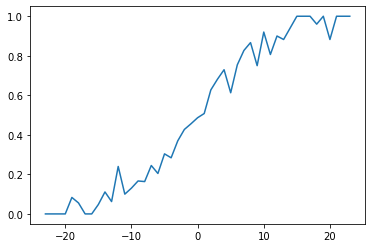

In [63]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [64]:
# Reference: https://stackoverflow.com/questions/17913330/fitting-data-using-univariatespline-in-scipy-python

spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5453774675839186
logloss of cvsplit 1: 0.5471583571436094
logloss of cvsplit 2: 0.547915506895444
logloss of cvsplit 3: 0.5468676619508354
logloss of cvsplit 4: 0.5447454184786995
logloss of cvsplit 5: 0.5481612133575013
logloss of cvsplit 6: 0.5450374625248287
logloss of cvsplit 7: 0.546110842849613
logloss of cvsplit 8: 0.5479917814607814
logloss of cvsplit 9: 0.5450909251633875


[<matplotlib.lines.Line2D at 0x20e81507080>]

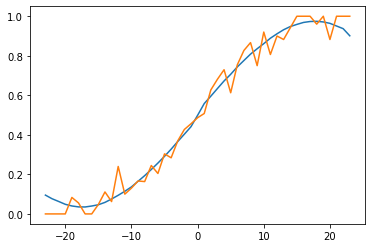

In [65]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [66]:
plot_df

,pred_int,spline,label
0,-23,0.095146,0.000000
1,-22,0.076819,0.000000
2,-21,0.062984,0.000000
3,-20,0.048632,0.000000
4,-19,0.040238,0.083333
5,-18,0.035488,0.055556
6,-17,0.035134,0.000000
7,-16,0.039937,0.000000
8,-15,0.046399,0.047619
9,-14,0.058335,0.111111


In [67]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5453774675839186
adjusted logloss of cvsplit 1: 0.5471583571436094
adjusted logloss of cvsplit 2: 0.547915506895444
adjusted logloss of cvsplit 3: 0.5468676619508354
adjusted logloss of cvsplit 4: 0.5447454184786995
adjusted logloss of cvsplit 5: 0.5481612133575013
adjusted logloss of cvsplit 6: 0.5450374625248287
adjusted logloss of cvsplit 7: 0.546110842849613
adjusted logloss of cvsplit 8: 0.5479917814607814
adjusted logloss of cvsplit 9: 0.5450909251633875


In [68]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5727720775070755
adjusted logloss of cvsplit 1: 0.5746754635619155
adjusted logloss of cvsplit 2: 0.5752123933653014
adjusted logloss of cvsplit 3: 0.5743133230508493
adjusted logloss of cvsplit 4: 0.5721641163625607
adjusted logloss of cvsplit 5: 0.5756865112898869
adjusted logloss of cvsplit 6: 0.572419588541965
adjusted logloss of cvsplit 7: 0.5735145297269876
adjusted logloss of cvsplit 8: 0.5753052985168399
adjusted logloss of cvsplit 9: 0.5724571625837785


In [69]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
).sort_values(['Season'])

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality
2062,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,...,1.516129,1.0,1.0,1,16,-15,2229,2247,inf,0.0
1014,2018,137,1420,74,1438,54,25.612903,58.451613,9.838710,25.774194,...,14.151515,1.0,1.0,16,1,15,2247,2229,0.0,inf


In [70]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5403257744468142
adjusted logloss of cvsplit 1: 0.5420598587675814
adjusted logloss of cvsplit 2: 0.5423703908737023
adjusted logloss of cvsplit 3: 0.5413692996855387
adjusted logloss of cvsplit 4: 0.5398191533250324
adjusted logloss of cvsplit 5: 0.5431880086629938
adjusted logloss of cvsplit 6: 0.5401585786999302
adjusted logloss of cvsplit 7: 0.5411431384969765
adjusted logloss of cvsplit 8: 0.5426316074174559
adjusted logloss of cvsplit 9: 0.5399353459152763


In [71]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5403257744468142
adjusted logloss of cvsplit 1: 0.5420598587675814
adjusted logloss of cvsplit 2: 0.5423703908737023
adjusted logloss of cvsplit 3: 0.5413692996855387
adjusted logloss of cvsplit 4: 0.5398191533250324
adjusted logloss of cvsplit 5: 0.5431880086629938
adjusted logloss of cvsplit 6: 0.5401585786999302
adjusted logloss of cvsplit 7: 0.5411431384969765
adjusted logloss of cvsplit 8: 0.5426316074174559
adjusted logloss of cvsplit 9: 0.5399353459152763


season
2003    0.543988
2004    0.509391
2005    0.494398
2006    0.559571
2007    0.443419
2008    0.474162
2009    0.483507
2010    0.563312
2011    0.604845
2012    0.568290
2013    0.611538
2014    0.588811
2015    0.515516
2016    0.583334
2017    0.504979
2018    0.600159
dtype: float64

# Submission

In [72]:
submission

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5
...,...,...
2273,2019_1449_1459,0.5
2274,2019_1449_1463,0.5
2275,2019_1458_1459,0.5
2276,2019_1458_1463,0.5


In [73]:
submission["Season"] = submission["ID"].apply(lambda x: x[:4]).astype(int)
submission["T1_TeamID"] = submission["ID"].apply(lambda x: x[5:9]).astype(int)
submission["T2_TeamID"] = submission["ID"].apply(lambda x: x[10:14]).astype(int)
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2019_1101_1113,0.5,2019,1101,1113
1,2019_1101_1120,0.5,2019,1101,1120
2,2019_1101_1124,0.5,2019,1101,1124
3,2019_1101_1125,0.5,2019,1101,1125
4,2019_1101_1133,0.5,2019,1101,1133
...,...,...,...,...,...
2273,2019_1449_1459,0.5,2019,1449,1459
2274,2019_1449_1463,0.5,2019,1449,1463
2275,2019_1458_1459,0.5,2019,1458,1459
2276,2019_1458_1463,0.5,2019,1458,1463


In [74]:
submission = pd.merge(submission, season_T1_boxscore_stat, on = ['Season', 'T1_TeamID'], how='left')
submission = pd.merge(submission, season_T2_boxscore_stat, on = ['Season', 'T2_TeamID'], how='left')
submission = pd.merge(submission, seeds_T1, on = ['Season', 'T1_TeamID'], how='left')
submission = pd.merge(submission, seeds_T2, on = ['Season', 'T2_TeamID'], how='left')
submission = pd.merge(submission, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how='left')
submission = pd.merge(submission, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how='left')
submission["Seed_diff"] = submission["T1_seed"] - submission["T2_seed"]

In [75]:
# Add Score Sum Feature
submission = pd.merge(submission, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T1_TeamID'],
                        right_on=['Season', 'TeamID'])
submission.rename(columns={'Score_Sum': 'T1_Score_Sum'}, inplace=True)
submission.drop(['TeamID'], axis=1, inplace=True)

submission = pd.merge(submission, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T2_TeamID'],
                        right_on=['Season', 'TeamID'])
submission.rename(columns={'Score_Sum': 'T2_Score_Sum'}, inplace=True)
submission.drop(['TeamID'], axis=1, inplace=True)

In [76]:
submission = pd.merge(submission, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
submission = pd.merge(submission, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [77]:
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_PointDiffmean,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality
0,2019_1101_1113,0.5,2019,1101,1113,25.296296,55.333333,7.370370,19.111111,9.148148,...,4.833333,15,11,1.0,1.0,4,1934,2332,6.669084e+127,3.232553e+145
1,2019_1101_1120,0.5,2019,1101,1120,25.296296,55.333333,7.370370,19.111111,9.148148,...,10.266667,15,5,1.0,1.0,10,1934,2379,6.669084e+127,5.463366e+144
2,2019_1101_1124,0.5,2019,1101,1124,25.296296,55.333333,7.370370,19.111111,9.148148,...,5.161290,15,9,1.0,0.0,6,1934,2227,6.669084e+127,1.308969e+145
3,2019_1101_1125,0.5,2019,1101,1125,25.296296,55.333333,7.370370,19.111111,9.148148,...,12.200000,15,11,1.0,0.5,4,1934,2606,6.669084e+127,2.158914e+128
4,2019_1101_1133,0.5,2019,1101,1133,25.296296,55.333333,7.370370,19.111111,9.148148,...,1.181818,15,15,1.0,1.0,0,1934,2190,6.669084e+127,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2019_1449_1459,0.5,2019,1449,1459,24.741935,54.129032,7.387097,21.258065,9.548387,...,13.666667,9,7,0.5,1.0,2,2182,2436,1.377461e+144,2.450319e+127
2274,2019_1449_1463,0.5,2019,1449,1463,24.741935,54.129032,7.387097,21.258065,9.548387,...,7.038462,9,14,0.5,0.5,-5,2182,2085,1.377461e+144,2.215261e+112
2275,2019_1458_1459,0.5,2019,1458,1459,26.000000,57.000000,7.290323,19.483871,8.064516,...,13.666667,5,7,1.0,1.0,-2,2158,2436,1.622904e+145,2.450319e+127
2276,2019_1458_1463,0.5,2019,1458,1463,26.000000,57.000000,7.290323,19.483871,8.064516,...,7.038462,5,14,1.0,0.5,-9,2158,2085,1.622904e+145,2.215261e+112


In [78]:
X_submission = submission[features].values
dtest = xgb.DMatrix(X_submission)

In [79]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [80]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
submission["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

submission.loc[(submission.T1_seed==1) & (submission.T2_seed==16), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==2) & (submission.T2_seed==15), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==3) & (submission.T2_seed==14), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==16) & (submission.T2_seed==1), 'Pred'] = 0.0
submission.loc[(submission.T1_seed==15) & (submission.T2_seed==2), 'Pred'] = 0.0
submission.loc[(submission.T1_seed==14) & (submission.T2_seed==3), 'Pred'] = 0.0

if COMPETITION_YEAR == 2019:
    submission[['ID','Pred']].to_csv("submission-Men-2019.csv", index = None)
elif COMPETITION_YEAR == 2020:
    submission[['ID','Pred']].to_csv("submission-Men-2020.csv", index = None)

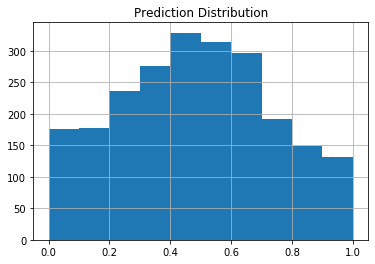

In [81]:
submission['Pred'].hist()
plt.title('Prediction Distribution');